In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
tf.compat.v1.disable_eager_execution()

from keras.layers import Input, Dense, Lambda, Layer, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.python.keras import backend
from keras.models import load_model

In [2]:
# data load
path = 'G:/My Drive/Fall 2020/AML/data/'

def load_data(dataset):
    train_orig = pd.read_csv(path + dataset + '.ts.data', ',').values.astype(np.float32)
    test_orig = pd.read_csv(path + dataset +'.valid.data', ',').values.astype(np.float32)
    return train_orig, test_orig

# parameters
dataset = ['nltcs', 'plants', 'book']
n_hidden, z_dim = 256, 2
batch_size = 128

# save model
save = True

In [4]:
# sampling function
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# elbo loss
def elbo(xins, y):
    reconstruction_loss = K.sum(K.binary_crossentropy(xins, y), axis=-1)
    kl_loss = K.mean(0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1))
    return K.mean(reconstruction_loss + kl_loss)

# log marginal
def nll(xins, y):
    return K.sum(K.binary_crossentropy(xins, y), axis=-1)


#############################################
nltcs training...
(16180, 16) (2156, 16)
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          4352        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense[0][0]                      
________

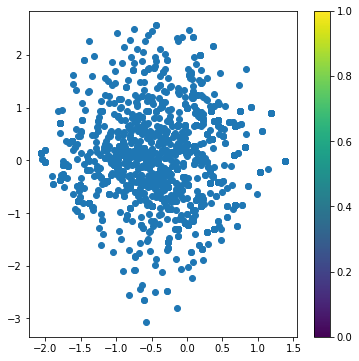


#############################################
plants training...
(17411, 69) (2320, 69)
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          17920       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            514         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_5[0][0]                    
_______

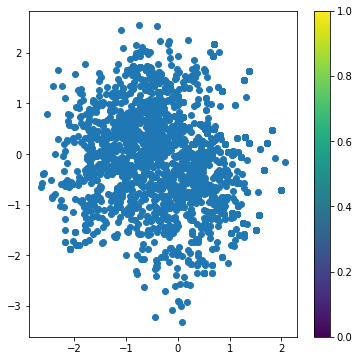


#############################################
book training...
(8699, 500) (1158, 500)
Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          128256      input_5[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2)            514         dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            514         dense_10[0][0]                   
________

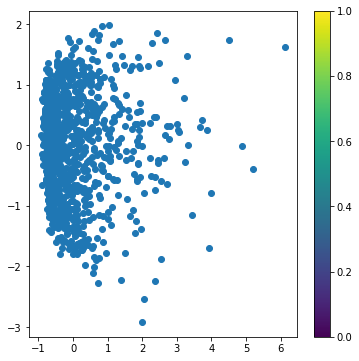

In [4]:
for name in dataset:

    if name == 'nltcs':
        xtrain, xtest = load_data(name)
    elif name == 'plants':
        xtrain, xtest = load_data(name)
    elif name == 'book':
        xtrain, xtest = load_data(name)
    else:
        print("enter valid dataset name")
    
    print('\n#############################################')
    print(name + ' training...')
    print(xtrain.shape, xtest.shape)
    
    # encoder
    xins = Input(shape=(xtrain.shape[1]))
    x1 = Dense(n_hidden, activation='relu')(xins)
    mu = Dense(z_dim, activation='linear')(x1)
    log_var = Dense(z_dim, activation='linear')(x1)
    z = Sampling()([mu, log_var])

    # decoder layers
    y_layer = Dense(n_hidden, activation='relu')
    y_final = Dense(xtrain.shape[1], activation='sigmoid')

    # calling above layers
    y_1 = y_layer(z)
    y_dec = y_final(y_1)
    vae = Model(xins, y_dec, name="VAE")
    vae.summary()
    vae.compile(optimizer='adam', loss=elbo)
    
    # train
    vae.fit(xtrain,
            xtrain,
           shuffle=True,
           epochs=5000,
           batch_size=batch_size,
           validation_data=(xtest, xtest),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
    
    # save model
    if save:
        vae.save('vae_' + name)

    #############################################
    
    # build separate encoder decoder from above trained model for visualization of ltent space
    encoder = Model(xins, mu, name="enocder")

    # build decoder
    decoder_input = Input(shape=(z_dim,))
    y_out = y_layer(decoder_input)
    y_decoded = y_final(y_out)
    decoder = Model(decoder_input, y_decoded, name="decoder")
    
    # Plot the latent space
    x_te_latent = encoder.predict(xtest, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1])
    plt.colorbar()
    plt.show()

In [9]:
# to evaluate on some test data, just use this cell
# keep dataset and models in same folder as this notebook file to run the "evaluate" function below

def evaluate(datasetname, num_samples):
    vae = load_model('vae_' + datasetname, custom_objects={'elbo': nll})
    print("\nVAE " + datasetname + " model loaded...")

    # load data
    _, xtest = load_data(datasetname)

    # test on random test samples
    random_indices = np.random.choice(xtest.shape[0], size=num_samples, replace=True)
    random_rows = xtest[random_indices, :]
    print(random_rows.shape)

    #############################################
    print('log marginal for given samples:')

    # reconstructed data
    recon = vae(random_rows)
    sess = backend.get_session()

    res = sess.run(-1 * K.mean( nll(random_rows, recon) ) )
    print(res)
    
    
datasetname = 'nltcs'
num_samples = 300
evaluate(datasetname, num_samples)

datasetname = 'plants'
evaluate(datasetname, num_samples)

datasetname = 'book'
evaluate(datasetname, num_samples)


VAE nltcs model loaded...
(300, 16)
log marginal for given samples:
-4.5646644

VAE plants model loaded...
(300, 69)
log marginal for given samples:
-11.569888

VAE book model loaded...
(300, 500)
log marginal for given samples:
-32.839306
